In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

from resalloc.fungible import AllocationProblem
from resalloc.fungible import utilities

from latexify import latexify
latexify()

In [2]:
device = 'cpu'
torch.manual_seed(0)
np.random.seed(0)

USE_DOUBLES = False
SOLVE_WITH_MOSEK = True

n_jobs = int(1e6)
n_resources = 4
resource_limits = torch.tensor([8e5, 1e5, 1e4, 1e3], device=device)

job_demands = None
#job_demands = torch.randint(1, 4, size=(n_jobs,))
#job_demands = torch.randint(1, 4, size=(n_jobs, n_resources))

throughput_matrix = torch.stack([
    torch.tensor(np.random.uniform(low=0.1, high=0.3, size=n_jobs)).float(),
    torch.tensor(np.random.uniform(low=0.1, high=0.5, size=n_jobs)).float(),
    torch.tensor(np.random.uniform(low=0.3, high=0.8, size=n_jobs)).float(),
    torch.tensor(np.random.uniform(low=0.6, high=1., size=n_jobs)).float(),
], dim=1)

throughput_matrix = throughput_matrix.to(device)

utility_fn = utilities.Log()

if USE_DOUBLES:
    resource_limits = resource_limits.double()
    throughput_matrix = throughput_matrix.double()
    if job_demands is None:
        job_demands = job_demands.double()

alloc_problem = AllocationProblem(
    throughput_matrix,
    resource_limits=resource_limits,
    job_demands=job_demands,
    utility_function=utility_fn
)
resource_limits

tensor([800000., 100000.,  10000.,   1000.])

In [3]:
if SOLVE_WITH_MOSEK:
    problem = alloc_problem.make_cvxpy_problem()
    problem.solve(cp.MOSEK, verbose=True)
    print(problem.objective.value)
    print(problem.constraints[1].dual_value)
    print(problem.status)
    
    OPT_VALUE = problem.objective.value / n_jobs
    OPT_PRICES = problem.constraints[1].dual_value

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Mar 31 02:30:08 PM: Your problem has 5000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 31 02:30:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 31 02:30:08 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 31 02:30:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 31 02:30:08 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 31 02:30:08 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -

(CVXPY) Mar 31 02:36:10 PM: Solver (including time spent in interface) took 3.493e+02 seconds
-1521834.9084590625
[0.70200381 1.75420477 3.90779292 6.19476232]
optimal


In [4]:
prices, stats = alloc_problem.solve(
    eps=1e-3, snapshot_throughputs=True, snapshot_resource_usage=True, verbose=True)
print(f'Solve took {stats.solve_time:.3e} seconds')
print('optimal value ', stats.utils[-1])
print('upper bound', stats.dual_values[-1])
prices

/home/akshay/envs/resalloc/lib/python3.8/site-packages/torch-1.8.1-py3.8-linux-x86_64.egg/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


Mar 31 02:39:19 PM: iteration 00 | utility=-1.73708 | dual_value=-1.4098 | gap=3.27e-01
Mar 31 02:39:20 PM: iteration 05 | utility=-1.53582 | dual_value=-1.51522 | gap=2.06e-02
Mar 31 02:39:22 PM: iteration 10 | utility=-1.52336 | dual_value=-1.52179 | gap=1.56e-03
Mar 31 02:39:22 PM: Converged in 012 iterations, with residual 9e-05
Solve took 3.735e+00 seconds
optimal value  -1.52191925
upper bound -1.52182925


tensor([0.0000, 0.7018, 1.7535, 3.9067, 6.1829])

In [5]:
# make feasible should be unnecessary here, since we're basically optimal
X_opt = alloc_problem.make_feasible(alloc_problem.X)
print('fraction jobs with slack ', (X_opt[:, 0] > 0).sum().item() / float(n_jobs))

fraction jobs with slack  0.183326


In [6]:
((X_opt[:, 1:] > 1e-6).sum(axis=1) == 2).sum() / n_jobs

tensor(0.1701)

In [7]:
torch.manual_seed(0)
np.random.seed(0)
targets = torch.tensor([0.2]*n_jobs, device=device).reshape(-1, 1)

priorities = torch.randint(low=1, high=3, size=(n_jobs, 1), device=device)

if USE_DOUBLES:
    targets = targets.double()
    priorities = priorities.double()

target_utility_fn = utilities.TargetPriority(targets, priorities)

priority_problem = AllocationProblem(
    throughput_matrix,
    resource_limits=resource_limits,
    utility_function=target_utility_fn,
)

In [8]:
if SOLVE_WITH_MOSEK:
    problem = priority_problem.make_cvxpy_problem()
    problem.solve(cp.MOSEK, verbose=True)
    print(problem.objective.value)
    print(problem.constraints[1].dual_value)
    print(problem.status)
    
    P_OPT_VALUE = problem.objective.value / n_jobs
    P_OPT_PRICES = problem.constraints[1].dual_value

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Mar 31 02:39:27 PM: Your problem has 5000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 31 02:39:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 31 02:39:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 31 02:39:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 31 02:39:27 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 31 02:39:27 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -

50  4.0e-08  1.0e+05  1.2e+05  9.99e-01   1.300162347e+03   1.236243878e+03   6.6e+01  69.85 
51  2.2e-08  9.9e+04  1.2e+05  1.00e+00   1.300709241e+03   1.238678219e+03   6.4e+01  71.02 
52  1.4e-08  8.3e+04  1.0e+05  9.99e-01   1.300904370e+03   1.248790669e+03   5.3e+01  72.18 
53  2.6e-09  7.6e+04  9.5e+04  1.00e+00   1.302123409e+03   1.253286920e+03   4.8e+01  73.29 
54  1.2e-09  7.1e+04  8.9e+04  9.99e-01   1.302172002e+03   1.256509220e+03   4.5e+01  74.39 
55  5.9e-10  6.2e+04  7.8e+04  1.00e+00   1.302390941e+03   1.262305576e+03   3.9e+01  75.51 
56  2.9e-10  4.7e+04  6.0e+04  1.00e+00   1.302936856e+03   1.272313746e+03   3.0e+01  76.62 
57  5.7e-11  4.1e+04  5.2e+04  1.00e+00   1.303346436e+03   1.276501644e+03   2.5e+01  77.75 
58  4.3e-11  3.4e+04  4.4e+04  1.00e+00   1.303352312e+03   1.280623875e+03   2.2e+01  78.92 
59  3.3e-11  3.2e+04  4.1e+04  1.00e+00   1.303420026e+03   1.282146896e+03   2.0e+01  80.05 
60  2.2e-11  2.4e+04  3.1e+04  1.00e+00   1.303527417e+03   

In [9]:
p_prices, p_stats = priority_problem.solve(
    eps=1e-3, snapshot_throughputs=True, snapshot_resource_usage=True, verbose=True)
print(f'Solve took {p_stats.solve_time:.3e} seconds')
print('optimal value ', p_stats.utils[-1])
print('upper bound', p_stats.dual_values[-1])
p_prices

Mar 31 02:41:36 PM: iteration 00 | utility=-0.0531892 | dual_value=0.0138123 | gap=6.70e-02
Mar 31 02:41:40 PM: iteration 05 | utility=-0.0087059 | dual_value=-0.000275979 | gap=8.43e-03
Mar 31 02:41:42 PM: iteration 10 | utility=-0.00327315 | dual_value=-0.000724643 | gap=2.55e-03
Mar 31 02:41:45 PM: iteration 15 | utility=-0.00298092 | dual_value=-0.000759396 | gap=2.22e-03
Mar 31 02:41:48 PM: iteration 20 | utility=-0.00525155 | dual_value=-0.00118052 | gap=4.07e-03
Mar 31 02:41:48 PM: Converged in 022 iterations, with residual 0.00024424
Solve took 1.346e+01 seconds
optimal value  -0.0014936761474609375
upper bound -0.0012494365234375


tensor([0.0000, 0.0012, 0.0634, 0.3785, 0.8734])

In [10]:
p_X_opt = priority_problem.make_feasible(priority_problem.X)
print('fraction jobs with slack ', (p_X_opt[:, 0] > 0).sum().item() / float(n_jobs))
((p_X_opt[:, 1:] > 1e-6).sum(axis=1) == 2).sum() / n_jobs

fraction jobs with slack  0.500805


tensor(0.4644)

In [11]:
# !pip install pymde
from pymde.quadratic import pca

embedding = pca(throughput_matrix, embedding_dim=1).flatten()
log_embedding = pca(X_opt, embedding_dim=1).flatten()
p_embedding = pca(p_X_opt, embedding_dim=1).flatten()

permutation = embedding.argsort()
log_perm = log_embedding.argsort()
p_perm = p_embedding.argsort()

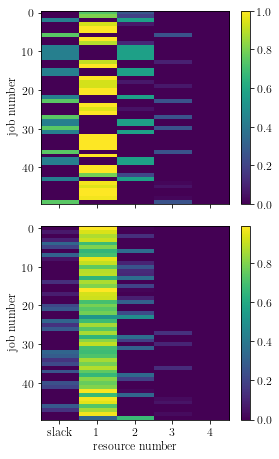

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((4.5/1.1, 7.2/1.1))

def plot_X(X, n_jobs=20, ax=None):
    sparsity_pattern = (X > 0).cpu().numpy()
    sparsity_pattern = sparsity_pattern * 1.

    if ax is None:
        fig = plt.figure()
        fig.set_size_inches(7, 8)
        ax = plt.gca()
    im = ax.imshow(X[:n_jobs].cpu().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['slack', 1, 2, 3, 4])
    ax.set_ylabel('job number')
    ax.set_yticks([0, 10, 20, 30, 40])

n_jobs = int(50)
plot_X(X_opt[permutation], n_jobs=n_jobs, ax=axs[0])
plot_X(p_X_opt[permutation], n_jobs=n_jobs, ax=axs[1])
axs[1].set_xlabel('resource number')
plt.tight_layout()
plt.savefig('allocation_matrices.pdf')

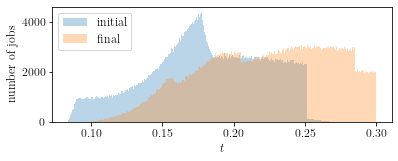

In [13]:
plt.figure(figsize=(5.7, 2.4))
plt.hist(stats.throughputs[0].cpu().numpy(), color='tab:blue', bins=500, label='initial', alpha=0.3)
plt.hist(stats.throughputs[-1].cpu().numpy(), color='tab:orange', bins=500, label='final', alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('number of jobs')
plt.legend(loc='upper left')
plt.tight_layout()

In [14]:
def _cdf(array, n_bins=None, ax=None, xlabel=None, label=None, color=None):
    array = np.sort(array)                                                       
    if n_bins is None:                                                           
        n_bins = min(array.size, 100000)                                         
    step = int(array.size / n_bins)                                              
    bins = np.arange(1, array.size + 1, step=step)                               
    if bins[-1] != array.size:                                                   
        bins = np.concatenate((bins, np.array([array.size])))                    
    heights = bins / float(array.size)                                           
                                                                                 
    if ax is None:
        ax = plt.gca()                                                               
    ax.step(array[bins - 1], heights, color=color, label=label)
    if xlabel is not None:
        ax.set_xlabel(xlabel)

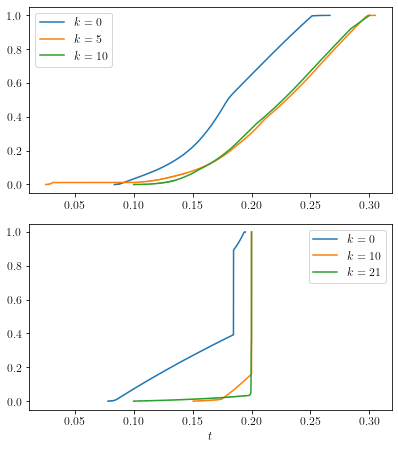

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((5.7, 6.4))

def plot_cdfs(throughputs, iters, ax, colors=None):
    for i in iters:
        _cdf(throughputs[i].cpu(), n_bins=5000, ax=ax, label=f'$k={i}$')
        
plot_cdfs(stats.throughputs, [0, 5, 10], axs[0])
plot_cdfs(p_stats.throughputs, [0, 10, 21], axs[1])
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('$t$')

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()
plt.savefig('throughput_distributions.pdf')

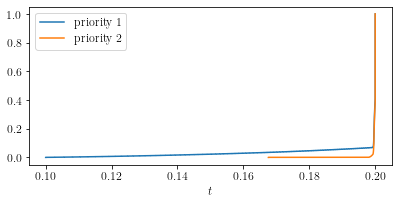

In [16]:
priorities = priority_problem.utility_fn.priorities.squeeze()
low_priority = priorities == 1
high_priority = ~low_priority

final_throughputs = p_stats.throughputs[-1]
low_priority_t = final_throughputs[low_priority]
high_priority_t = final_throughputs[high_priority]


fig = plt.figure()
fig.set_size_inches((5.7, 3.))
ax = plt.gca()
        
def plot_cdfs(throughputs, ax, label, colors=None):
    _cdf(throughputs.cpu(), n_bins=5000, ax=ax, label=label)
        
plot_cdfs(low_priority_t,  ax, 'priority $1$')
plot_cdfs(high_priority_t, ax, 'priority $2$')
ax.legend()
ax.set_xlabel('$t$')

plt.tight_layout()
plt.savefig('throughput_distributions_by_priority.pdf')

prices  tensor([0.0000, 0.7051, 1.7601, 3.9182, 6.1504])
prices  tensor([0.0000, 0.0022, 0.0546, 0.3705, 0.8207])


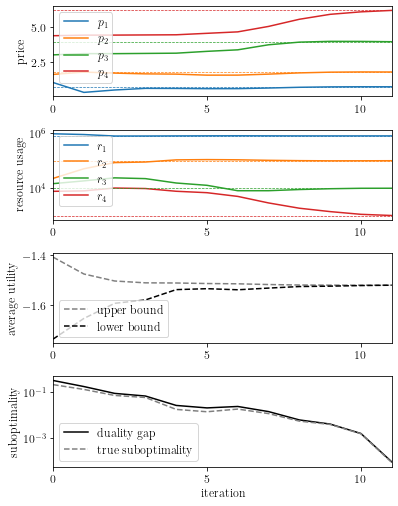

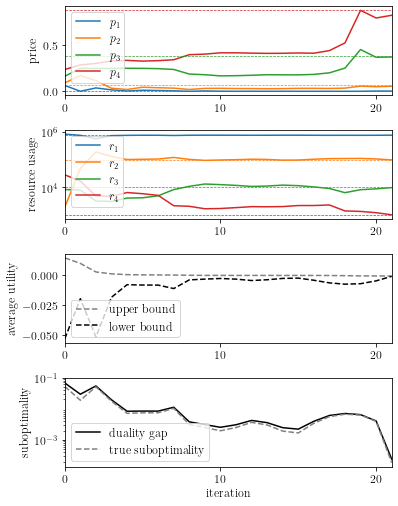

In [17]:
def plot_four(alloc_problem, stats, opt_prices, opt_value, xticks, figname=None):
    fig, axs = plt.subplots(4, 1)
    fig.set_size_inches((5.7, 7.2))

    stop_at = np.argmax(np.array(stats.gaps) < 1e-3)
    price_history = torch.stack(stats.snapshots)
    axs[0].plot(price_history[:, 1].cpu().numpy(), label='$p_1$')
    axs[0].plot(price_history[:, 2].cpu().numpy(), label='$p_2$')
    axs[0].plot(price_history[:, 3].cpu().numpy(), label='$p_3$')
    axs[0].plot(price_history[:, 4].cpu().numpy(), label='$p_4$')
    axs[0].axhline(opt_prices[0], linestyle='--', color='tab:blue', linewidth=0.7)
    axs[0].axhline(opt_prices[1], linestyle='--', color='tab:orange', linewidth=0.7)
    axs[0].axhline(opt_prices[2], linestyle='--', color='tab:green', linewidth=0.7)
    axs[0].axhline(opt_prices[3], linestyle='--', color='tab:red', linewidth=0.7)
    axs[0].set_ylabel('price')
    axs[0].set_xticks(xticks)
    axs[0].set_xlim(0, len(stats.gaps) - 1)
    axs[0].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[0].legend(loc='upper left')

    resource_history = torch.stack(stats.resource_usage)[:, 1:].cpu().numpy()
    axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].plot(resource_history[:, 0], label='$r_1$')
    axs[1].plot(resource_history[:, 1], label='$r_2$')
    axs[1].plot(resource_history[:, 2], label='$r_3$')
    axs[1].plot(resource_history[:, 3], label='$r_4$')
    axs[1].axhline(alloc_problem.resource_limits[1], linestyle='--', color='tab:blue', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[2], linestyle='--', color='tab:orange', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[3], linestyle='--', color='tab:green', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[4], linestyle='--', color='tab:red', linewidth=0.7)
    axs[1].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[1].set_ylabel('resource usage')
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper left')
    axs[1].set_xticks(xticks)
    axs[1].set_xlim(0, len(stats.gaps) - 1)

    axs[2].plot(np.array(stats.dual_values), color='gray', linestyle='--', label='upper bound')
    axs[2].plot(stats.utils, color='black', linestyle='--', label='lower bound')
    axs[2].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[2].set_ylabel('average utility')
    axs[2].legend(loc='lower left')
    axs[2].set_xticks(xticks)
    axs[2].set_xlim(0, len(stats.gaps) - 1)

    axs[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[3].plot((np.array(stats.dual_values) - np.array(stats.utils)), color='black', label='duality gap')
    axs[3].plot((opt_value - np.array(stats.utils)), color='gray', linestyle='--', label='true suboptimality')
    axs[3].set_ylabel('suboptimality')
    axs[3].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[3].set_yscale('log')
    axs[3].set_yticks([1e-1, 1e-3])
    axs[3].set_xticks(xticks)
    axs[3].legend(loc='lower left')
    axs[3].set_xlim(0, len(stats.gaps) - 1)
    axs[3].set_xlabel('iteration')

    plt.tight_layout()
    if figname is not None:
        plt.savefig(figname)
    print('prices ', price_history[-1])
    

plot_four(alloc_problem, stats, OPT_PRICES, OPT_VALUE, [0, 5, 10], 'progress_log.pdf')
plot_four(priority_problem, p_stats, P_OPT_PRICES, P_OPT_VALUE, [0, 10, 20], 'progress_target.pdf')